In [ ]:
# Будем обращаться к линукс-ядру напрямую с помощью команд на "!"
# Будем устанавливать окружение из пакета Stable Baseline для OpenAI (для того, чтобы можно было использовать движок в колабе)
# Код, представленный в документации разработчика
!apt install swig cmake libopenmpi-dev zlib1g-dev # cmake - сборка - аналог GNU Make, но с другим синтаксисом, libopenmpi-dev распределённые вычисления в кластере для дебиан, zlib1g-dev - сжатие траффика
!pip install stable-baselines==2.5.1 box2d box2d-kengz # устанавливаем непосредственно сам stable baseline и движок box2d

# если убрать " > /dev/null 2>&1" то работа сервера будет выведена на экран, а этой командой перемещаем все в фоновый режим
!pip install gym pyvirtualdisplay > /dev/null 2>&1 # установка пакета для рендера видео
!pip install xvfbwrapper # установка обертки для пакета, который позволит воспроизводить видео в ячейке колаба  
!apt-get update # обновляем все пакеты до новейшей версии, чтобы все пакеты "подружились"
!sudo apt-get install xvfb # установка удаленного сервера, благодаря которому видео будет воспроизводиться в ячейке колаба
!apt-get install xdpyinfo # пакет для вывода процессов, происходящих на сервере

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
0 upgraded, 0 newly installed, 0 to remove and 64 not upgraded.
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:9 http://security.ubuntu.com/ub

Подключаем нужные библиотеки:

In [ ]:
import gym         # Load the Gym module from OpenAi, which is an environment for reinforcement learning
import numpy as np # Import numpy
import tensorflow.keras as keras        # Import keras
from tensorflow.keras.models import Model, load_model, save_model # From keras import the class Model and the function load_model separately
from tensorflow.keras.layers import * #Импортируем все слои кераса
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD # From keras load these optimizers
from pyvirtualdisplay import Display  #Модуль для создания окна дисплея
from tensorflow.keras import backend as K
import time                                # Import the time module
import matplotlib.pyplot as plt            # Import matplotlib pyplot for data visualization
import tensorflow as tf               #Import tensorflow
import math
import cv2
import pickle
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках
import random
 
%matplotlib inline

In [ ]:
# Создаем объект дисплей, таким образом, симуляцию можно будет наблюдать в колабе
display = Display(visible=0, size=(1400, 900))
display.start()

tf.compat.v1.disable_eager_execution()

Подключаем гугл-диск:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
LOSS_CLIP_VALUE = 0.2
gamma = 0.99
lamda = 0.9
epochs_per_iteration = 10
log_standard_deviation = -0.4
batch_size = 512

root_path = '/content/drive/My Drive/pretrained_networks'

env = gym.make('BipedalWalker-v3')
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
def gaussian_likelihood_keras(actions, predictions): 
  predict_sum = -0.5 * (((actions - predictions)/(K.exp(log_standard_deviation)))**2 + 2*log_standard_deviation + K.log(2*math.pi))
  return K.sum(predict_sum, axis=1)

def gaussian_likelihood_numpy(actions, predictions): 
  predict_sum = -0.5 * (((actions - predictions)/(np.exp(log_standard_deviation)))**2 + 2*log_standard_deviation + np.log(2*np.pi))
  return np.sum(predict_sum, axis=1)

In [ ]:
def actor_ppo_loss_continuous(y_true, y_pred):
  advantages, old_log_probabilities, actions = y_true[:, 0], y_true[:, 1], y_true[:, 2:]
  current_log_probabilities = gaussian_likelihood_keras(actions, y_pred)
  probability_ratio = K.exp(current_log_probabilities - old_log_probabilities)
  clipped_ratio = K.clip(probability_ratio, 1 - LOSS_CLIP_VALUE, 1 + LOSS_CLIP_VALUE)

  loss_component_1 = probability_ratio * advantages  #Считаем первую часть ошибки политики
  loss_component_2 = clipped_ratio * advantages      #Считаем вторую часть ошибки политики

  actor_loss_value = -K.mean(K.minimum(loss_component_1, loss_component_2))

  return actor_loss_value

def critic_ppo_loss(y_true, y_pred):
  labels, old_values = y_true[:, 0], y_true[:, 1]
  clipped_value_loss = old_values + K.clip(y_pred - old_values, -LOSS_CLIP_VALUE, LOSS_CLIP_VALUE)
  loss_component_1 = (labels - clipped_value_loss) ** 2
  loss_component_2 = (labels - y_pred) ** 2
              
  value_loss = 0.5 * K.mean(K.maximum(loss_component_1, loss_component_2))
  return value_loss

In [ ]:
def get_GAE(rewards, current_values, next_values, dones):
  deltas = [reward + (1 - done) * gamma * next_value - current_value for reward, next_value, current_value, done in zip(rewards, next_values, current_values, dones)]
  deltas = np.array(deltas)

  generalized_advantage_estimates = np.zeros_like(deltas)
  for i in reversed(range(len(rewards) - 1)):
    generalized_advantage_estimates[i] = deltas[i] + (1 - dones[i]) * gamma * lamda * deltas[i + 1]

  targets = generalized_advantage_estimates + current_values
  generalized_advantage_estimates -= generalized_advantage_estimates.mean()
  generalized_advantage_estimates /= generalized_advantage_estimates.std()
  return generalized_advantage_estimates, targets

In [ ]:
#Создадим класс, который будет содержать нашу нейронную сеть
def Actor_Critic_Model(model_type = 'actor'): 
  state_input_layer = Input(shape = (state_size))
  x = Dense(512, activation = 'relu', kernel_initializer=tf.random_normal_initializer(stddev=0.01))(state_input_layer)
  x = Dense(256, activation = 'relu', kernel_initializer=tf.random_normal_initializer(stddev=0.01))(x)
  x = Dense(64, activation = 'relu', kernel_initializer=tf.random_normal_initializer(stddev=0.01))(x)
  if model_type.lower() == 'actor':
    output_layer = Dense(action_size, activation = 'tanh')(x) #Выходной слой актёра имеет количество нейроннов равное количеству действий и активационную функцию softmax
    model = Model(state_input_layer, output_layer)
    model.compile(optimizer = Adam(learning_rate = 5e-4), loss = actor_ppo_loss_continuous)
  else:
    output_layer = Dense(1)(x)                                #Выходной слой критика имеет 1 нейрон и активационную функцию linear
    model = Model(state_input_layer, output_layer)
    model.compile(optimizer = Adam(learning_rate = 5e-4), loss = critic_ppo_loss)
  return model

actor_model = Actor_Critic_Model(model_type = 'actor')        #Создаем объект модели
critic_model = Actor_Critic_Model(model_type = 'critic')      #Создаем объект модели

In [ ]:
def train_algorithm(current_states, actions, rewards, next_states, dones, old_log_probabilities):
  current_states = np.array(current_states, dtype = np.float32).squeeze()
  actions = np.array(actions, dtype = np.float32)
  next_states = np.array(next_states, dtype = np.float32).squeeze()
  old_log_probabilities = np.array(old_log_probabilities, dtype = np.float32)

  old_values = critic_model.predict(current_states)           #Предсказываем вероятности принятия действий и значения состояний
  next_values = critic_model.predict(next_states)
  
  advantages, targets = get_GAE(rewards, old_values, next_values, dones)
  actor_labels = np.hstack([advantages.reshape(-1, 1), old_log_probabilities.reshape(-1, 1), actions.reshape(-1, action_size)])
  critic_labels = np.expand_dims(np.hstack([targets, old_values]), axis = -1)

  actor_model.fit(current_states, actor_labels, batch_size = batch_size, epochs = epochs_per_iteration, verbose = 0)
  critic_model.fit(current_states, critic_labels, batch_size = batch_size, epochs = epochs_per_iteration, verbose = 0)

In [ ]:
def load_training_progress():
  actor_model.load_weights(f'{root_path}/BipedalWalker_PPO_actor.h5')
  critic_model.load_weights(f'{root_path}/BipedalWalker_PPO_critic.h5')
  with open(f'{root_path}/BipedalWalker_PPO_training.txt', 'rb') as f:
    all_episode_rewards, episode_number = pickle.load(f)
  return all_episode_rewards, episode_number

def save_training_progress():
  actor_model.save_weights(f'{root_path}/BipedalWalker_PPO_actor.h5')
  critic_model.save_weights(f'{root_path}/BipedalWalker_PPO_critic.h5')
  with open(f'{root_path}/BipedalWalker_PPO_training.txt', 'wb') as f:
    pickle.dump([all_episode_rewards, episode_number], f)

In [ ]:
#Функция для выбора действия принимает на вход состояние среды
def choose_action(state, test_mode = False):      
  #Из предикта модели принимаем вероятности для действий И значение критика (значение критика нам не нужно, его принимаем только чтобы избежать ошибку)
  predictions = actor_model.predict(np.expand_dims(state, axis = 0))      

  if not test_mode:
    actions = predictions + np.random.uniform(-1, 1, size = predictions.shape) * np.exp(log_standard_deviation)
    actions = np.clip(actions, -1, 1)

    log_probabilities = gaussian_likelihood_numpy(actions, predictions)
    return actions, log_probabilities
  else:
    return predictions

#Дальше, создаем функцию для отображения наград за эпизод. По сколько здесь будут только отображаться награды, мы можем отобразить все данные на одном полотне.
def show_scores(episode_rewards):
  output.clear() #Удаляем предыдущий вывод ячейки
  plt.figure(figsize = (20, 8))                                    #Устанавливаем большой размер полотна
  plt.plot(episode_rewards, linestyle = '--', label = 'Награда за эпизод')         #Отрисовываем награды
  plt.plot(moving_average(episode_rewards), label = 'Скользящее среднее награды')  #Считаем и отрисовываем скользящее среднее от награды
  plt.xlabel('Эпизод', fontsize = 12)                                          #Добавляем лейблы осей
  plt.ylabel('Награда', fontsize = 12)
  plt.legend()         #Создаем легенду

  plt.show()           #Выводим график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 20 значений.
def moving_average(data, width = 100): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))        #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

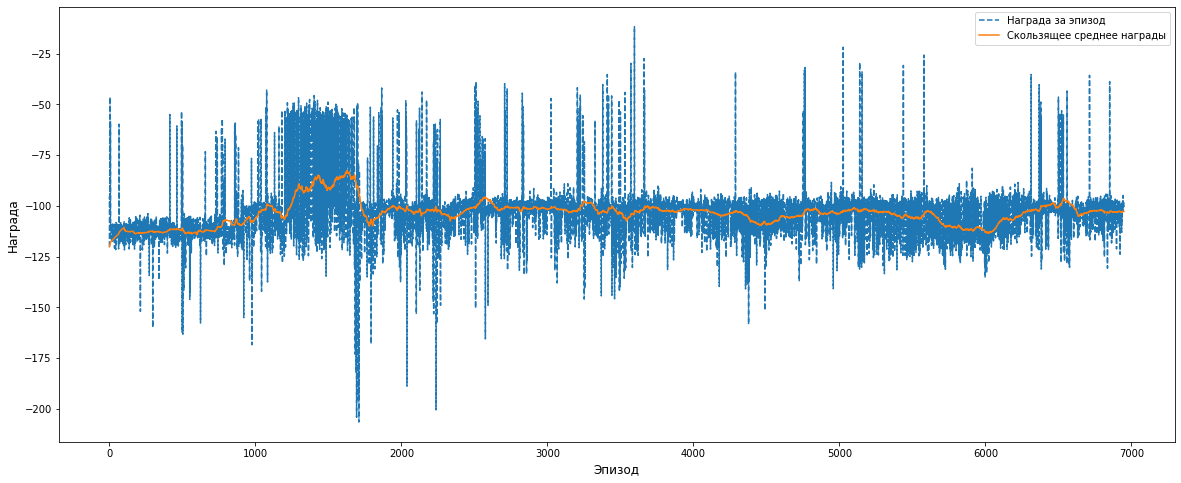

In [ ]:
load_pretrained = False

env = gym.make("BipedalWalker-v3")
if load_pretrained:
  all_episode_rewards, episode_number = load_training_progress()
else:
  all_episode_rewards = []
  episode_number = 0

episode_reward = 0
current_state = env.reset()
while True:
  episode_current_states, episode_next_states, episode_actions, episode_rewards, episode_dones, episode_log_probabilities = [], [], [], [], [], []
  for i in range(batch_size):
    actions, log_probabilities = choose_action(current_state)
    next_state, reward, done, info = env.step(actions.flatten())
    episode_reward += reward

    episode_current_states.append(current_state)
    episode_next_states.append(next_state)
    episode_actions.append(actions.flatten())
    episode_rewards.append(reward)
    episode_dones.append(done)
    episode_log_probabilities.append(log_probabilities)
    current_state = next_state.copy()

    if done:
      current_state = env.reset()
      episode_number += 1
      all_episode_rewards.append(episode_reward)
      done, episode_reward = False, 0
      if episode_number % 50 == 0:
        save_training_progress()
        show_scores(all_episode_rewards)

  train_algorithm(episode_current_states, episode_actions, episode_rewards, episode_next_states, episode_dones, episode_log_probabilities)